# Milestone 3

#### Authors: Weiru Chen, Togo Kida, Daniel Cox, Shuyuan Xiao

In [120]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pylast
import json
import os
import matplotlib.pyplot as pyp

In [121]:
raw_features = []
for i in range(100):
    file = pd.read_csv("../playlists/df_playlist_features_"+str(i)+".csv")
    raw_features.append(file)


## Get tags for songs in the playlists
Get tags from Last.fm and use the tags as response variable

In [96]:
#unique tags threshold
threshold = 3000
#threshold = 1000
unique_tags = []
with open("../lastfm_unique_tags.txt", 'r') as f:
    for line in f:
        tag_freq = line.split('\t')
        if int(tag_freq[1]) > threshold:
            unique_tags.append(tag_freq[0])
        else:
            break

In [97]:
#create all zero value dictionary

def get_zero_dict():
    zeros_dict = {}
    for tag in unique_tags:
        zeros_dict.update({tag: 0.0})
    return zeros_dict

## Data Wrangling for the model to predict tags of a playlist
To prepare the data for the random forest model, take the mean value of features of all the songs in the playlist

In [98]:
feature_names = list(raw_features[0].columns)[4:]
#print(feature_names)

labels = []
with open('../labels_100_playlists.json') as json_file:
    data = json.load(json_file)
    label_columns = list(data[0].keys())
    for item in data:
        #label = list(item.values())
        #label = np.array(label)*100
        #labels.append(list(label))
        labels.append(list(item.values()))
    
features = []
for raw_playlist in raw_features:
    raw_playlist = raw_playlist.drop(columns=['track_name', 'artist', 'id','Unnamed: 0'])
    new_feature_array_playlist = list(raw_playlist.mean())
    features.append(new_feature_array_playlist)

overall_data = []
for i in range(len(features)):
    overall_data.append(features[i]+labels[i])

overall_df = pd.DataFrame(overall_data, columns = feature_names+label_columns)
overall_df.head()

,acousticness,danceability,speechiness,instrumentalness,liveness,energy,valence,duration_ms,key,mode,...,World Music,genius,noise,saxophone,Favorite Artists,indietronica,feelgood,new,folk-rock,pretty
0,0.085044,0.663922,0.107875,0.000689,0.192404,0.779078,0.645608,222076.627451,5.117647,0.705882,...,0.001154,0.000385,0.0000,0.0,0.000962,0.0000,0.001731,0.001346,0.0,0.000577
1,0.166732,0.493655,0.089239,0.228118,0.174761,0.686868,0.472711,299176.157895,4.578947,0.552632,...,0.000000,0.000000,0.0000,0.0,0.000000,0.0000,0.000000,0.000256,0.0,0.000000
2,0.273359,0.671952,0.096359,0.000648,0.170416,0.690095,0.565460,219076.174603,4.984127,0.507937,...,0.000000,0.000000,0.0000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.007812
3,0.266913,0.509253,0.066359,0.210820,0.197497,0.624924,0.460534,229373.898990,5.090909,0.707071,...,0.000000,0.000200,0.0075,0.0,0.002800,0.0165,0.001400,0.000200,0.0,0.001700
4,0.181532,0.582188,0.041513,0.086992,0.169556,0.636631,0.489375,256603.562500,3.187500,0.812500,...,0.000000,0.000000,0.0000,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.000000


With the tags from the Last.fm, for each song, we find top n tags and set their weights to be 1 (others 0).

In [99]:
feature_names = list(raw_features[0].columns)[4:]
#print(feature_names)

top_n_tags = 20

labels = []
with open('../labels_100_playlists.json') as json_file:
    data = json.load(json_file)
    label_columns = list(data[0].keys())
    for item in data:
        label = list(item.values())
        sorted_label_top_n = sorted(label, reverse=True)[0:top_n_tags]
        new_label = [0]*len(label)
        for num in sorted_label_top_n:
            new_label[label.index(num)] = 1
        
        labels.append(new_label)
        #labels.append(list(item.values()))
    
features = []
for raw_playlist in raw_features:
    raw_playlist = raw_playlist.drop(columns=['track_name', 'artist', 'id','Unnamed: 0'])
    new_feature_array_playlist = list(raw_playlist.mean())
    features.append(new_feature_array_playlist)

overall_data = []
for i in range(len(features)):
    overall_data.append(features[i]+labels[i])

overall_df = pd.DataFrame(overall_data, columns = feature_names+label_columns)
overall_df.head()

,acousticness,danceability,speechiness,instrumentalness,liveness,energy,valence,duration_ms,key,mode,...,World Music,genius,noise,saxophone,Favorite Artists,indietronica,feelgood,new,folk-rock,pretty
0,0.085044,0.663922,0.107875,0.000689,0.192404,0.779078,0.645608,222076.627451,5.117647,0.705882,...,0,0,0,0,0,0,0,0,0,0
1,0.166732,0.493655,0.089239,0.228118,0.174761,0.686868,0.472711,299176.157895,4.578947,0.552632,...,0,0,0,0,0,0,0,0,0,0
2,0.273359,0.671952,0.096359,0.000648,0.170416,0.690095,0.565460,219076.174603,4.984127,0.507937,...,0,0,0,0,0,0,0,0,0,1
3,0.266913,0.509253,0.066359,0.210820,0.197497,0.624924,0.460534,229373.898990,5.090909,0.707071,...,0,0,0,0,0,0,0,0,0,0
4,0.181532,0.582188,0.041513,0.086992,0.169556,0.636631,0.489375,256603.562500,3.187500,0.812500,...,0,0,0,0,0,0,0,0,0,0


## EDA and Visualizations

## Motivation of Models

Since there are billions of users and playlists, and the playlists are created and changing all the time, it is extremely time consuming and quite unrealizable to use last.fm api to get all the latest tags of all the songs in order to recommend similar songs with respect to the playlists. Besides, there are many unpopular and newly released songs that might never be recommended to any user, as they might have no reliable tags. In this case, we can make a pool for those newly released songs (via released date) and unpopular songs (via listening counts) and then use our model (such as artificial neural networks model) to train them. With the pool of predicted tags for these songs, we can compute the distances between these songs and the playlists. And we can recommend songs in this pool with the closest distances to the playlists.


## Tree Models
Decision Trees and Random Forests (Difficult to tune, overfitting, not ideal for coldstart and multi-dimensional class labels)

In [100]:
feature_names = list(raw_features[0].columns)[4:]
#print(feature_names)

top_n_tags = 1

labels = []
with open('../labels_100_playlists.json') as json_file:
    data = json.load(json_file)
    label_columns = list(data[0].keys())
    for item in data:
        label = list(item.values())
        sorted_label_top_n = sorted(label, reverse=True)[0:top_n_tags]
        new_label = [0]*len(label)
        for num in sorted_label_top_n:
            new_label[label.index(num)] = 1
        
        labels.append(new_label)
        #labels.append(list(item.values()))
    
features = []
for raw_playlist in raw_features:
    raw_playlist = raw_playlist.drop(columns=['track_name', 'artist', 'id','Unnamed: 0'])
    new_feature_array_playlist = list(raw_playlist.mean())
    features.append(new_feature_array_playlist)

overall_data = []
for i in range(len(features)):
    overall_data.append(features[i]+labels[i])

overall_df = pd.DataFrame(overall_data, columns = feature_names+label_columns)
overall_df.head()

,acousticness,danceability,speechiness,instrumentalness,liveness,energy,valence,duration_ms,key,mode,...,World Music,genius,noise,saxophone,Favorite Artists,indietronica,feelgood,new,folk-rock,pretty
0,0.085044,0.663922,0.107875,0.000689,0.192404,0.779078,0.645608,222076.627451,5.117647,0.705882,...,0,0,0,0,0,0,0,0,0,0
1,0.166732,0.493655,0.089239,0.228118,0.174761,0.686868,0.472711,299176.157895,4.578947,0.552632,...,0,0,0,0,0,0,0,0,0,0
2,0.273359,0.671952,0.096359,0.000648,0.170416,0.690095,0.565460,219076.174603,4.984127,0.507937,...,0,0,0,0,0,0,0,0,0,0
3,0.266913,0.509253,0.066359,0.210820,0.197497,0.624924,0.460534,229373.898990,5.090909,0.707071,...,0,0,0,0,0,0,0,0,0,0
4,0.181532,0.582188,0.041513,0.086992,0.169556,0.636631,0.489375,256603.562500,3.187500,0.812500,...,0,0,0,0,0,0,0,0,0,0


Train-test split

In [101]:
from sklearn.model_selection import train_test_split

#standardize (normalize X_df)
X_df = overall_df[feature_names]
#X_df=(X_df-X_df.mean())/X_df.std()
y_df = overall_df[label_columns]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2)


In [102]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth = 50, min_samples_split = 3, min_samples_leaf = 1,
                                   criterion = "gini").fit(X_train, y_train)
train_tree_acc = tree_model.score(X_train, y_train)
test_tree_acc = tree_model.score(X_test, y_test)
print("Training accuracy:", train_tree_acc)
print("Test accuracy:", test_tree_acc)

Training accuracy: 0.9
Test accuracy: 0.25


In [103]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators = 100, max_depth = 100, criterion = "entropy",
                                            min_samples_split = 3, min_samples_leaf = 2,
                                            max_features = "sqrt").fit(X_train, y_train)
train_tree_acc = random_forest_model.score(X_train, y_train)
test_tree_acc = random_forest_model.score(X_test, y_test)
print("Training accuracy:", train_tree_acc)
print("Test accuracy:", test_tree_acc)

Training accuracy: 0.5375
Test accuracy: 0.05


## CNN Model 
(Convoluted Neural Networks)

In [104]:
playlist_features = []
valid_data_indices = []
for i in range(0, 100):
    feature_sing = pd.read_csv("../playlists/df_playlist_features_" + str(i) + ".csv")
    feature_sing = feature_sing.drop(columns=['track_name', 'artist', 'id','Unnamed: 0'])
    feature_sing = feature_sing.dropna()
    feature_sing = feature_sing.to_numpy()
    num_songs = feature_sing.shape[0]
    if (num_songs >= 30):
        valid_data_indices.append(i)
        playlist_features.append(feature_sing[:30, ].reshape((30, 13, 1)))
playlist_features = np.array(playlist_features)
print(len(valid_data_indices))
playlist_features.shape

66


(66, 30, 13, 1)

In [105]:
# standardize features
playlist_features_mean = np.mean(playlist_features, axis=(0, 1), keepdims = True)
playlist_features_std = np.std(playlist_features, axis=(0, 1), keepdims = True)
playlist_features = (playlist_features - playlist_features_mean) / playlist_features_std

In [106]:
# read in labels
playlist_tags = []
with open('../labels_100_playlists.json') as json_file:
    raw_label = json.load(json_file)
    for i in range(len(raw_label)):
        # filter labels with valid features
        if i in valid_data_indices:
            label = raw_label[i]
            label = np.array(list(label.values()))
            playlist_tags.append(label)

    playlist_tags = np.array(playlist_tags)

In [107]:
# train-test split get random indices
import random
from random import sample
random.seed( 209 )
test_indices = random.sample(range(0, 66), 7)

# split features
train_features = []
test_features = []
for i in range(len(playlist_features)):
    if i in test_indices:
        test_features.append(playlist_features[i])
    else:
        train_features.append(playlist_features[i])

train_features = np.array(train_features)
test_features = np.array(test_features)

# split labels
train_labels = []
test_labels = []
for i in range(len(playlist_tags)):
    if i in test_indices:
        test_labels.append(playlist_tags[i])
    else:
        train_labels.append(playlist_tags[i])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [108]:
from tensorflow.keras import layers
from tensorflow.keras import models

input_shape = train_features[0].shape
num_category = train_labels[0].shape[0]

##model building
cnn_model = models.Sequential()
#convolutional layer with rectified linear unit activation
cnn_model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
cnn_model.add(layers.Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
cnn_model.add(layers.Flatten())
#fully connected to get all relevant data
cnn_model.add(layers.Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
cnn_model.add(layers.Dropout(0.2))
#output a softmax to squash the matrix into output probabilities
cnn_model.add(layers.Dense(num_category, activation='sigmoid'))

In [109]:
# Use adaDelta as the adaptive learning rate
cnn_model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
                 metrics = ['accuracy'])

In [110]:
# Train Model
# too few data to have a batch_size
batch_size = 5
num_epoch = 30
model_log = cnn_model.fit(train_features, train_labels,
          epochs=num_epoch,
          verbose=1,
          validation_data=(test_features, test_labels))

Train on 59 samples, validate on 7 samples
Epoch 1/30
59/59 [==============================] - 1s 11ms/sample - loss: 0.6768 - accuracy: 0.2751 - val_loss: 0.5972 - val_accuracy: 0.3577
Epoch 2/30
59/59 [==============================] - 0s 891us/sample - loss: 0.5740 - accuracy: 0.3439 - val_loss: 0.4591 - val_accuracy: 0.3884
Epoch 3/30
59/59 [==============================] - 0s 925us/sample - loss: 0.4542 - accuracy: 0.3789 - val_loss: 0.3181 - val_accuracy: 0.4192
Epoch 4/30
59/59 [==============================] - 0s 857us/sample - loss: 0.3439 - accuracy: 0.4076 - val_loss: 0.2071 - val_accuracy: 0.4526
Epoch 5/30
59/59 [==============================] - 0s 923us/sample - loss: 0.2558 - accuracy: 0.4349 - val_loss: 0.1293 - val_accuracy: 0.4724
Epoch 6/30
59/59 [==============================] - 0s 922us/sample - loss: 0.1916 - accuracy: 0.4519 - val_loss: 0.0833 - val_accuracy: 0.4864
Epoch 7/30
59/59 [==============================] - 0s 903us/sample - loss: 0.1349 - accuracy:

In [111]:
score = cnn_model.evaluate(train_features, train_labels, verbose=1)
print(score)

59/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [112]:
cnn_model.predict(train_features)
cnn_test_predicted = cnn_model.predict(test_features)
cnn_test_predicted

array([[0.11977851, 0.17834803, 0.07897523, ..., 0.00959024, 0.00188956,
        0.00198025],
       [0.10152051, 0.15518576, 0.05911651, ..., 0.00617781, 0.00094599,
        0.00106183],
       [0.10319871, 0.18662894, 0.0691357 , ..., 0.00634164, 0.00103772,
        0.00114375],
       ...,
       [0.17124304, 0.24540654, 0.11427289, ..., 0.02585408, 0.0058116 ,
        0.00603634],
       [0.10441217, 0.15533176, 0.06189975, ..., 0.00545532, 0.00081649,
        0.00097898],
       [0.09604675, 0.12648892, 0.04759368, ..., 0.00460861, 0.00056863,
        0.00071366]], dtype=float32)

In [113]:
score = cnn_model.evaluate(test_features, test_labels, verbose=1)
print(score)

7/1 [==================================================================================================================================================================================================================] - 0s 482us/sample - loss: 0.0379 - accuracy: 0.4896
[0.03793178126215935, 0.4895725]


Now with the probabilities, we can find use k nearest neighbors method to recommend songs for the user with specific playlist. Metric method 1: use the exact predicted probabilities and the normalized weights of the tags of the songs (by dividing 100), compute the mean squared difference. Metric method 2: classifiy the tags into 1 and 0 and compute the distance between the predicted tags and actual tags of the song.

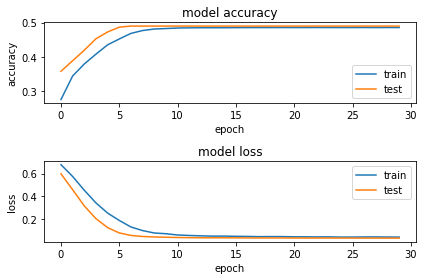

In [140]:
# plotting the metrics
fig = pyp.figure()
pyp.subplot(2,1,1)
pyp.plot(model_log.history['accuracy'])
pyp.plot(model_log.history['val_accuracy'])
pyp.title('model accuracy')
pyp.ylabel('accuracy')
pyp.xlabel('epoch')
pyp.legend(['train', 'test'], loc='lower right')

pyp.subplot(2,1,2)
pyp.plot(model_log.history['loss'])
pyp.plot(model_log.history['val_loss'])
pyp.title('model loss')
pyp.ylabel('loss')
pyp.xlabel('epoch')
pyp.legend(['train', 'test'], loc='upper right')
pyp.tight_layout()

## Random select a sample that contains candidate songs considered for the recommendation


In [114]:

# playlists = []
# random_indices = np.random.choice([i for i in range(1000)], size = 10)

# # load data into pandas dataframe
# for idx in random_indices:
#     songs_df = pd.read_csv("songs/songs{}.csv".format(idx))

#     # get playlists into dictionaries and store in a list

#     id_nums = set(songs_df['pid'].tolist())
#     songs_df = songs_df.groupby("pid")

#     for id in id_nums:
#         playlist = songs_df.get_group(id)
#         playlists.append(playlist.to_dict())

# # store the list of dictionaries into json file
# with open('random_playlists', 'w') as fout:
#     json.dump(playlists, fout)


read in random_playlists json file and randomly sample n playlists from the json file

In [115]:

# import random

# n = 100
# with open('random_playlists.json') as json_file:
#     data = json.load(json_file)
#     random_data = random.sample(data, n)
#     #print(len(random_data))


concatenate pairs of artists and track names of each track into one list

In [79]:

# playlists_artist_tracks = []
# for playlist in random_data:
#     artist_names = list(playlist.get("artist_name").values())
#     track_names = list(playlist.get("track_name").values())
#     artist_tracks = zip(artist_names, track_names)
#     playlists_artist_tracks += list(artist_tracks)
# print(len(playlists_artist_tracks))


get the normalized tag weights of these randomly sampled songs

In [80]:
# songs_with_tags = {}

# for track in playlists_artist_tracks:
#     tag_dict = get_zero_dict()
#     tags_with_weights = get_tags_from_track(track[0], track[1])
#     if tags_with_weights is not None and len(tags_with_weights) != 0:
#         for pair in tags_with_weights:
#             tag_dict.update({pair[0]: pair[1]/100.0})
#     print(tag_dict)
#     songs_with_tags.update({(track[0], track[1]): list(tag_dict.values())})

dump to json file

In [81]:
# candidates_with_tags = {}

# for key_tuple in list(songs_with_tags.keys()):
#     #turn tuple of artist_track into 'artist_name*,*track_name'
#     candidates_with_tags.update({str(key_tuple[0])+'*,*'+str(key_tuple[1]): songs_with_tags.get(key_tuple)})

# with open('candidates_with_tags', 'w') as fout:
#     json.dump(candidates_with_tags, fout)


## KNN Model to recommend songs (Currently using k=1)

Songs Recommended by CNN Model

In [82]:
#read in json file as dictionary
with open('../candidates_with_tags.json') as json_file:
    data = json.load(json_file)
songs_with_tags = data

In [83]:
# INPUT: tags for candidate songs, and the predicted tags of one playlist in the test dataset from a model
# OUTPUT: a song recommendation
def make_recommendation(candidate_tags, playlist_predicted_tag, random_songs):    
    min_distance = float('inf');
    rec = -1;
    for c in range(len(candidate_tags)):
        candidate = list(random_songs.values())[c]
        #each_distance = sum((np.array(candidate) - np.array(playlist_predicted_tag)) ** 2)
        each_distance = sum((candidate - playlist_predicted_tag) ** 2)
        if each_distance < min_distance:
            min_distance = each_distance;
            rec = c;
    return rec;

In [84]:
### Predict by KNN ### 
candidate_tags = list(songs_with_tags.keys())
recommendations = []

test_predicted = cnn_test_predicted

#playlists_artist_tracks can be replaced by accessing the dumped json file "candidates_with_tags"
playlists_artist_tracks = songs_with_tags
random_songs = playlists_artist_tracks

for each_playlist_predicted_tag in test_predicted:
#     print(each_playlist_predicted_tag)
    rec_for_test = make_recommendation(candidate_tags, each_playlist_predicted_tag, random_songs)
    recommendations.append(rec_for_test)
print(recommendations)

[4, 4, 4, 4, 4567, 4, 4]


In [85]:
songs_recommended = [];
for rec in recommendations:
    rec_track = tuple(candidate_tags[rec].split("*,*"))
    songs_recommended.append(rec_track)
print(songs_recommended)

[('Disclosure', 'Omen - Radio Edit'), ('Disclosure', 'Omen - Radio Edit'), ('Disclosure', 'Omen - Radio Edit'), ('Disclosure', 'Omen - Radio Edit'), ('2 LIVE CREW', 'Mega Mixx Iii'), ('Disclosure', 'Omen - Radio Edit'), ('Disclosure', 'Omen - Radio Edit')]
